In [1]:
import warnings
import pickle
import sys

warnings.filterwarnings('ignore')

# add paths for modules
sys.path.append('../visualization')
sys.path.append('../features')
sys.path.append('../datawrangling')

# import modules
import dataloader_paths, dataloader_geo
import visualize
import geometry_utils
from maritime_traffic_network import MaritimeTrafficNetwork
from MOGen_path_prediction import MOGenPathPrediction
import prediction_model_evaluation_metrics as metrics

In [2]:
# Load a network from pickle
datasize = 'full'
location = 'tromso'
model_date = '202204'
train_dates = ['202205']
test_dates = ['202206']
DP_tol = 10
min_samples = 13

network_name = model_date+'_waypoints_DP'+str(DP_tol)+'_HDBSCAN'+str(min_samples)+'_'+location+'_'+datasize+'_UTM'
network_path = '../../models/networks/best_networks/' + network_name + '.obj'
fileObj = open(network_path, 'rb')
network = pickle.load(fileObj)
fileObj.close()
network.hyperparameters

{'Data': '../../data/processed/202204_points_tromso_cleaned_meta_full_dualSplit_2.parquet',
 'DP_tolerance': 10,
 'clustering_method': 'HDBSCAN',
 'clustering_metric': 'mahalanobis',
 'clustering_min_samples': 13,
 'clustering_min_cluster_size': 13,
 'clustering_eps': 0,
 'clustering_metric_V': array([[1.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 1.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.01, 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.01, 0.  ],
        [0.  , 0.  , 0.  , 0.  , 1.  ]]),
 'graph_generation_max_distance': 20,
 'graph_generation_max_angle': 45}

In [3]:
# Load training data from file
path_prefix = '../../data/paths/'
training_paths = dataloader_paths.load_path_training_data(path_prefix, network_name, train_dates, data_version='')

In [4]:
# Train MOGen Model
model = MOGenPathPrediction()
print(f'Training MOGen Model on {len(training_paths)} paths...')
model.train(training_paths, max_order=3, model_selection=True)

Training MOGen Model on 1393 paths...


order:  3; log_L (8 prcs): 100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.33it/s]

Selected optimal maximum order K=1 from candidates.
MOGen model
- Model Selection ------------------------------------
 K  |   nodes     edges   |   log L    dof         AIC
 1  |    658      31743   | -18676.49  1855   41062.98
 2  |   1813      31743   | -15135.05  6401   43072.09
 3  |   3637      31743   | -12947.34 22040   69974.68


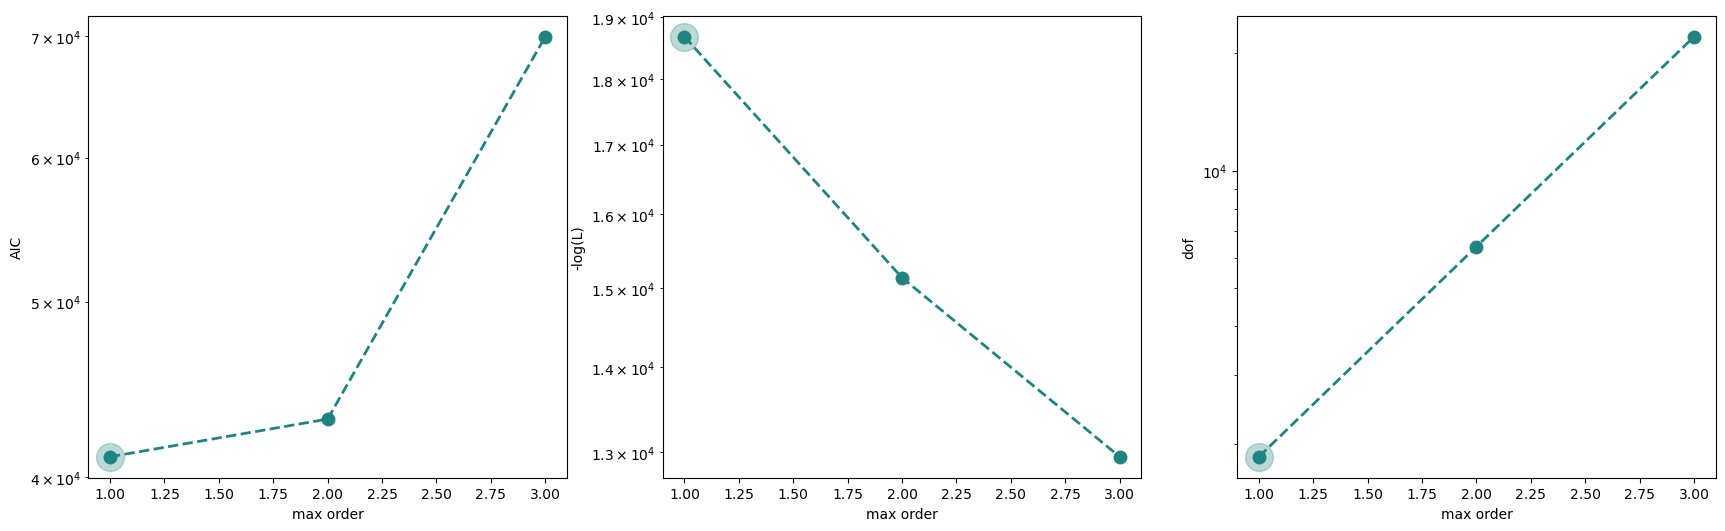

In [5]:
model.model.plot()

In [6]:
# Load test data from file
selection_start = 0
selection_end = -1
selection_step = 2
traj_path_prefix = '../../data/processed/'
test_paths = dataloader_paths.load_path_test_data(path_prefix, network_name, test_dates, 
                                                  selection_start, selection_end, selection_step, data_version='')
test_trajectories = dataloader_geo.load_trajectories(traj_path_prefix, location, network.crs, test_dates)

In [7]:
##### MAKE PREDICTIONS ######
prediction_task = 'path'  # 'next_nodes' or 'path'
n_walks = 100
n_start_nodes = 1
n_steps = 2        # only needed for next nodes prediction
n_predictions = 1

predictions = model.predict(prediction_task, test_paths, network.G, 
                            n_start_nodes=n_start_nodes, n_steps=n_steps, 
                            n_predictions=n_predictions, n_walks=n_walks)

Making predictions for 724 samples
Progress: 10%...20%...30%...40%...50%...60%...70%...80%...90%...Done!


Evaluating 724 samples for path prediction task
Progress: 10%...20%...30%...40%...50%...60%...70%...80%...90%...Done!


Time elapsed: 0.32 minutes


Percentage of unsuccessful predictions: 8.84%
Mean SSPD: 274.17m
Median SSPD: 137.58m
Mean choice_accuracy: 0.4687


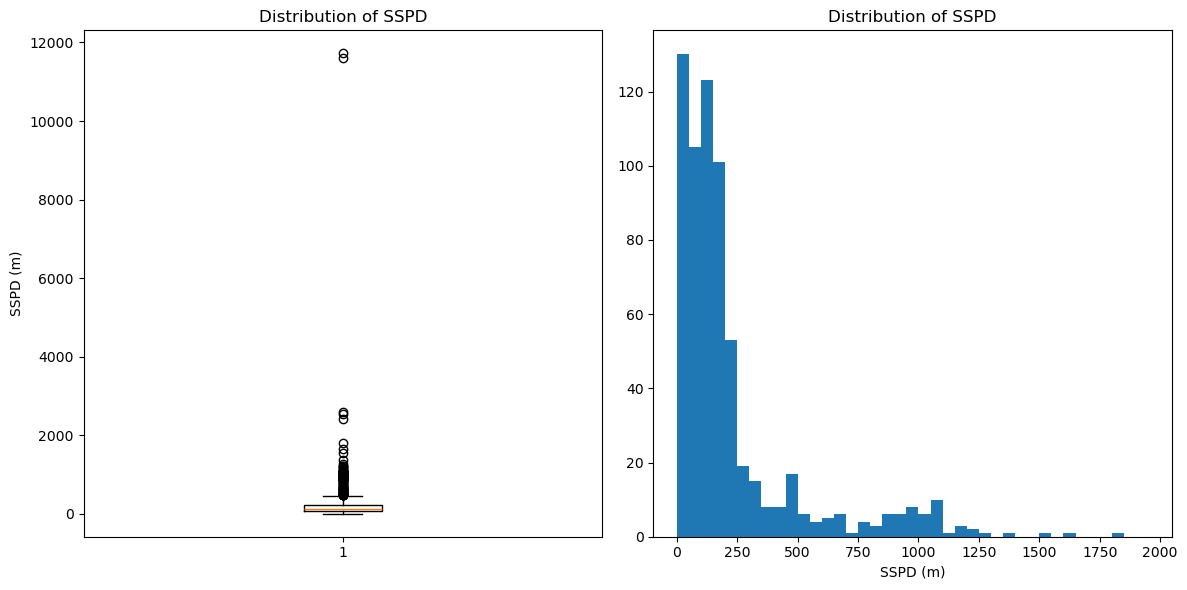

In [8]:
# evaluate
eval_mode = 'trajectory'
evaluation_results, fig = metrics.evaluate_given_predictions(prediction_task, predictions, test_trajectories, 
                                                             network, n_start_nodes=n_start_nodes, n_steps=n_steps, eval_mode=eval_mode)

In [9]:
evaluation_results

,mmsi,true_path,predicted_path,distances,SSPD,choice_accuracy
0,210055000_0_2022-06-01 09:31:46,"(130, 129, 128, 4, 350, 349, 323, 309, 455, 45...",[],[],NaN,NaN
0,210189000_0_2022-06-24 06:55:42,"(185, 180, 179, 224, 204, 217, 247, 296, 298, ...","(185, 179, 178, 223, 236, 217, 247, 296, 298, ...","[61.88069404176346, 62.98170930914535, 58.0670...",190.774008,0.466667
0,210189000_36_2022-06-30 09:45:01,"(466, 463, 462, 449, 439, 426, 429, 435, 437, ...","(466, 463, 25, 449, 439, 426, 429, 435, 437, 3...","[7.0398506521261845, 7.083555601088871, 7.1278...",97.695445,0.473684
0,211102000_0_2022-06-03 02:00:05,"(366, 352, 359, 374, 384, 375, 364, 468)","(366, 352, 359, 374, 384, 379, 380, 316, 351, ...","[85.59819088972199, 83.48624364252181, 82.8094...",200.426452,0.571429
0,211102000_35_2022-06-12 22:36:12,"(313, 3, 356, 322, 326, 341, 342, 338, 345)","(313, 343, 346, 337, 339, 330, 324, 325, 342, ...","[207.98205835265136, 189.28847506635475, 170.5...",618.543999,0.250000
...,...,...,...,...,...,...
0,314258000_2_2022-06-12 10:32:40,"(505, 503, 484, 485, 486, 475, 460, 461, 456, ...","(505, 503, 484, 485, 486, 487, 475, 460, 456, ...","[10.558536920301592, 12.527626888007578, 9.930...",265.802572,0.225806
0,314318000_0_2022-06-06 19:06:52,"(130, 128, 4, 354, 350, 349, 323, 388, 393, 41...","(130, 128, 4, 350, 349, 323, 388, 393, 392, 39...","[86.4967567283235, 78.94956983060564, 76.48456...",1156.785203,0.265306
0,314318000_5_2022-06-07 01:38:31,"(34, 166, 313, 343, 346, 337, 339, 340, 334, 3...","(34, 166, 313, 343, 346, 337, 339, 340, 326, 3...","[306.1577054273363, 275.2067526187743, 241.668...",161.810370,0.692308
0,314377000_0_2022-06-12 14:12:15,"(108, 47)","(108, 47)","[437.4876253531852, 433.24078640349126, 422.19...",405.269945,1.000000


In [10]:
# plot predictions with the MOGen model
prediction_task = 'next_nodes'
example = test_paths.iloc[3]
mmsi = example.mmsi
start_node = [example.path[0]]
end_node = example.path[-1]
true_path = example.path
trajectory = test_trajectories.get_trajectory(mmsi)

if prediction_task == 'next_nodes':
    predictions = model.predict_next_nodes(start_node=start_node, G=network.G, n_predictions=3, n_steps=3, n_walks=200)
if prediction_task == 'path':
    predictions, flag = model.predict_path(start_node, end_node, network.G, n_predictions=5, n_walks=2000, verbose=True)

map = visualize.map_prediction_and_ground_truth(predictions, start_node, trajectory, true_path, network, 
                                                min_passages=1, opacity=0.2, location=location, end_node=end_node)
map.save('../../reports/maps/'+network_name+'_MOGen_predictions.html')
print(f'Map saved under {"../../reports/maps/"+network_name+"_MOGen_predictions.html"}')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


Map saved under ../../reports/maps/202204_waypoints_DP10_HDBSCAN13_tromso_full_UTM_MOGen_predictions.html
